In [37]:
import pandas as pd
import numpy as np
from keras.preprocessing import text, sequence
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing , metrics#, decomposition, model_selection, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pickle
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
df = pd.read_csv("../data/normalized_texts_labels.csv",encoding="utf-8")
df = df[["normalized_text","fake"]]
df.columns = ["texts","labels"]
print("# of NaN of text:" + str(df["texts"].isnull().sum()))
print("# of NaN of label:" + str(df["labels"].isnull().sum()))
df = df.dropna()
print("dataset size:" + str(df.shape))

# of NaN of text:109
# of NaN of label:0
dataset size:(26491, 2)


In [3]:
train_texts, test_texts, train_labels, test_labels = train_test_split(df.texts, df.labels, 
                                                      stratify=df.labels, 
                                                      random_state=12345, 
                                                      test_size=0.1, shuffle=True)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, 
                                                      stratify=train_labels, 
                                                      random_state=12345, 
                                                      test_size=0.1, shuffle=True)

# Feature extractions & encoding

In [4]:
label_encoder = preprocessing.LabelBinarizer()
label_encoder.fit(df["labels"])
train_labels_encoded, val_labels_encoded, test_labels_encoded = \
    label_encoder.transform(train_labels), \
    label_encoder.transform(val_labels), \
    label_encoder.transform(test_labels)

In [5]:
feature_extractor_tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
feature_extractor_tfv.fit(df["texts"])
train_texts_tfv, val_texts_tfv, test_texts_tfv = \
    feature_extractor_tfv.transform(train_texts), \
    feature_extractor_tfv.transform(val_texts), \
    feature_extractor_tfv.transform(test_texts)

In [6]:
feature_extractor_ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')
feature_extractor_ctv.fit(df["texts"])
train_texts_ctv, val_texts_ctv, test_texts_ctv = \
    feature_extractor_ctv.transform(train_texts), \
    feature_extractor_ctv.transform(val_texts), \
    feature_extractor_ctv.transform(test_texts)

In [7]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(df["texts"])

In [8]:
# used in wordvec and cnn
text_tokens = tokenizer.texts_to_sequences(df["texts"])
max_tokens_one_sent = 0
min_tokens_one_sent = 1000000000
for doc in text_tokens:
    max_tokens_one_sent = max(max_tokens_one_sent, len(doc))
    min_tokens_one_sent = min(min_tokens_one_sent, len(doc))
print("Max # of tokens in docs: " + str(max_tokens_one_sent))
print("Min # of tokens in docs: " + str(min_tokens_one_sent))

Max # of tokens in docs: 14736
Min # of tokens in docs: 1


In [9]:
def create_embedding_matrix(word_vector_file,tokenizer):
    embeddings_index = {}
    for i, line in enumerate(open(word_vector_file)):
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
embedding_matrix = create_embedding_matrix('../wordvecs/wiki-news-300d-1M.vec',tokenizer)

In [10]:
def generate_word_sequence(texts,feature_dimension,tokenizer):
    text_tokens = tokenizer.texts_to_sequences(texts)
    text_seqences = sequence.pad_sequences(text_tokens, maxlen=feature_dimension)
    return text_seqences

Features we have right now:
* train_texts_ctv, val_texts_ctv, test_texts_ctv
* train_texts_tfv, val_texts_tfv, test_texts_tfv
* train_labels_encoded, val_labels_encoded, test_labels_encoded

Wordvec features:
* embedding_matrix
* text_tokens (tokenizer)
* Function generate_word_sequence() used to generate wordvec features. Example usage: 
generate_word_sequence(df.texts,max_tokens_one_sent,tokenizer)
* max_tokens_one_sent: used to set the padding of text sequence

# Modeling Training

In [11]:
from sklearn.linear_model import LogisticRegression
clf_lr_tfv = LogisticRegression(C=1.0)
clf_lr_tfv.fit(train_texts_tfv, train_labels_encoded)
clf_lr_ctv = LogisticRegression(C=1.0)
clf_lr_ctv.fit(train_texts_ctv, train_labels_encoded)

/Users/james/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/james/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
from sklearn.naive_bayes import MultinomialNB
clf_nb_tfv = MultinomialNB()
clf_nb_tfv.fit(train_texts_tfv, train_labels_encoded)
clf_nb_ctv = MultinomialNB()
clf_nb_ctv.fit(train_texts_ctv, train_labels_encoded)

/Users/james/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/james/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# Model Eval

In [13]:
# list of classifier
clf_names = ["LR tfv","NB tfv","LR ctv","NB ctv"]
clf_feature_list = ["tfv","tfv","ctv","ctv"]
clf_list = [clf_lr_tfv, clf_nb_tfv, clf_lr_ctv, clf_nb_ctv]

In [14]:
prediction_prob_list = []
for i in range(len(clf_list)):
    if clf_feature_list[i] == "tfv":
        prediction_prob_list.append(clf_list[i].predict_proba(val_texts_tfv)[:,1])
    elif clf_feature_list[i] == "ctv":
        prediction_prob_list.append(clf_list[i].predict_proba(val_texts_ctv)[:,1])
    else:
        raise ValueError("invalid feature categories!")

In [25]:
# Accuracy score for all classifier
accuracy_list = []
for i in range(len(clf_names)):
    accuracy_list.append(metrics.accuracy_score(val_labels_encoded,prediction_prob_list[i]>0.5))

In [36]:
# Is there an overfitting on above four models?
prediction_prob_on_train_list = []
for i in range(len(clf_list)):
    if clf_feature_list[i] == "tfv":
        prediction_prob_on_train_list.append(clf_list[i].predict_proba(train_texts_tfv)[:,1])
    elif clf_feature_list[i] == "ctv":
        prediction_prob_on_train_list.append(clf_list[i].predict_proba(train_texts_ctv)[:,1])
    else:
        raise ValueError("invalid feature categories!")
accuracy_on_train_set_list = []
for i in range(len(clf_list)):
    accuracy_on_train_set_list.append(metrics.accuracy_score(train_labels_encoded,prediction_prob_on_train_list[i]>0.5))
for i in range(len(clf_list)):
    print("model " + clf_names[i])
    print("\t train acc %0.4f" % accuracy_on_train_set_list[i])
    print("\t validation acc %0.4f" % accuracy_list[i])

model LR tfv
	 train acc 0.9778
	 validation acc 0.9447
model NB tfv
	 train acc 0.7553
	 validation acc 0.7220
model LR ctv
	 train acc 0.9999
	 validation acc 0.9480
model NB ctv
	 train acc 0.9970
	 validation acc 0.9283


Text(0.5,1,'CNN training accuracy')

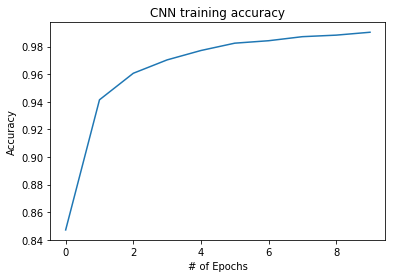

In [41]:
# This model trains on training set only.
cnn_model = load_model('../saved_models/cnn_trained_on_trainset.model')
with open('../saved_models/cnn.model.history.trained_on_trainset', 'rb') as file_pi:
    history = pickle.load(file_pi)
plt.figure()
plt.plot(history['acc'])
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.title('CNN training accuracy')

In [42]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14736)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 14736, 300)        40498500  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 14736, 300)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14734, 100)        90100     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
__________

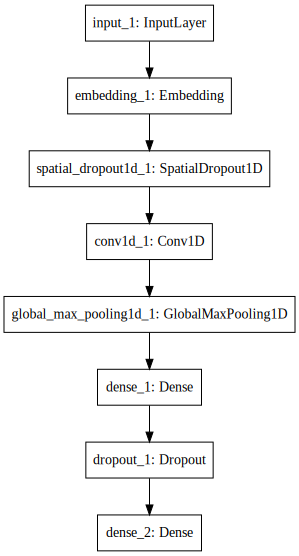

In [43]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cnn_model).create(prog='dot', format='svg'))

In [15]:
prediction_prob_list.append(
    cnn_model.predict(
        generate_word_sequence(val_texts,max_tokens_one_sent,tokenizer)
        ).squeeze()
    )
clf_names.append("CNN wordvec")

In [18]:
# Is there an overfitting for CNN?
prediction_prob_on_trainset = cnn_model.predict(
        generate_word_sequence(train_texts,max_tokens_one_sent,tokenizer)
        ).squeeze()
acc_train_cnn = metrics.accuracy_score(train_labels_encoded,prediction_prob_on_trainset>0.5)
acc_val_cnn = metrics.accuracy_score(val_labels_encoded,prediction_prob_list[-1]>0.5)
print("CNN accuracy on training set: %0.4f"%acc_train_cnn)
print("CNN accuracy on validation set: %0.4f"%acc_val_cnn)

CNN accuracy on training set: 0.9975
CNN accuracy on validation set: 0.9564


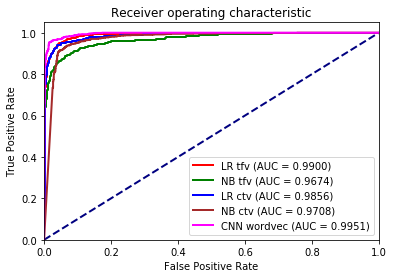

In [19]:
# Plot ROC curve
color_list = ["red","green","blue","brown","magenta","teal"]
plt.figure()
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # random guess base line
auc_list = [] # for later plotting
for i in range(len(clf_names)):
    fpr, tpr, _  = metrics.roc_curve(val_labels_encoded,prediction_prob_list[i])
    roc_auc = metrics.auc(fpr, tpr)
    auc_list.append(roc_auc)
    lw = 2
    plt.plot(fpr, tpr, color=color_list[i],
         lw=lw, label=clf_names[i]+' (AUC = %0.4f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

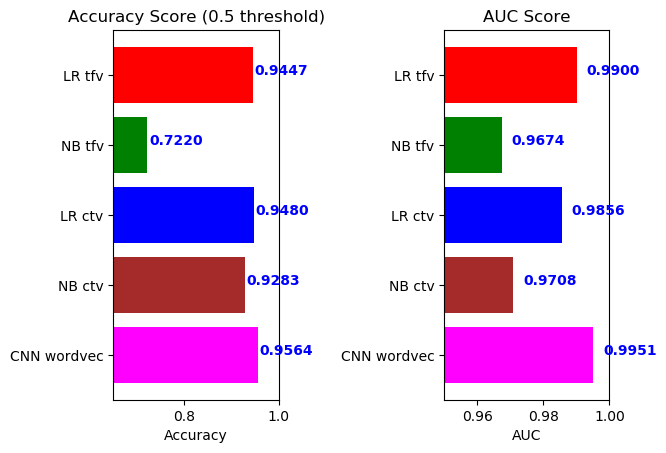

In [21]:
plt.rcdefaults()
fig, ax = plt.subplots(nrows=1, ncols=2)
y_pos = np.arange(len(accuracy_list))
ax[0].barh(y_pos, accuracy_list, align='center',
        color=color_list)
ax[0].set_xlim(0.65,1)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(clf_names)
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('Accuracy')
ax[0].set_title('Accuracy Score (0.5 threshold)')
for i, v in enumerate(accuracy_list):
    ax[0].text(v + 0.003, i, '%0.4f' % v, color='blue', fontweight='bold')

y_pos = np.arange(len(auc_list))
ax[1].barh(y_pos, auc_list, align='center',
        color=color_list)
ax[1].set_xlim(0.95,1)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(clf_names)
ax[1].invert_yaxis()  # labels read top-to-bottom
ax[1].set_xlabel('AUC')
ax[1].set_title('AUC Score')
for i, v in enumerate(auc_list):
    ax[1].text(v + 0.003, i, '%0.4f' % v, color='blue', fontweight='bold')

plt.subplots_adjust(wspace = 1)
plt.show()

# Final evaluation on test set
Since CNN + wordvec shows the best performance on validation set, we choose it as final models for this excercise.
A model is trained on the training set and validation set. We have saved it in the disk and will have to reload it to memory.

In [22]:
cnn_model_on_train_val_set = load_model('../saved_models/cnn_trained_on_trainset_and_valset.model')
predition_prob = cnn_model_on_train_val_set.predict(
        generate_word_sequence(test_texts,max_tokens_one_sent,tokenizer)
        ).squeeze()

In [23]:
# Accuracy on test set
print(metrics.accuracy_score(test_labels_encoded,predition_prob>0.5))

0.9747169811320755


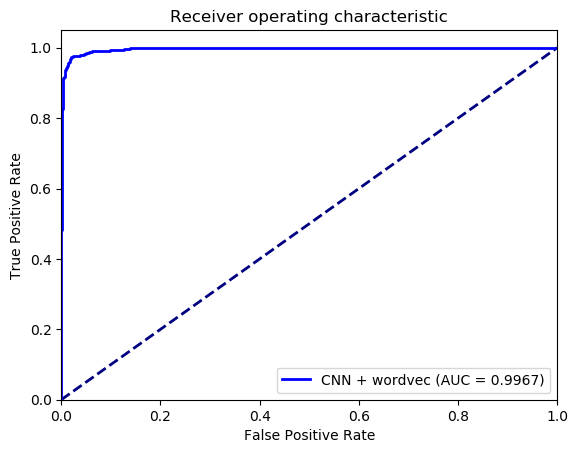

In [24]:
# Plot ROC curve
plt.figure()
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # random guess base line
fpr, tpr, _  = metrics.roc_curve(test_labels_encoded,predition_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color="b",
         lw=lw, label='CNN + wordvec (AUC = %0.4f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()